In [36]:
!pip install -r requirements.txt



Number of Channels: 1
Sample Width (bytes): 2
Sample Rate: 19531 Hz
Number of Frames: 98689
Compression Type: not compressed
Bits per Sample: 16
Determined Data Type: int16


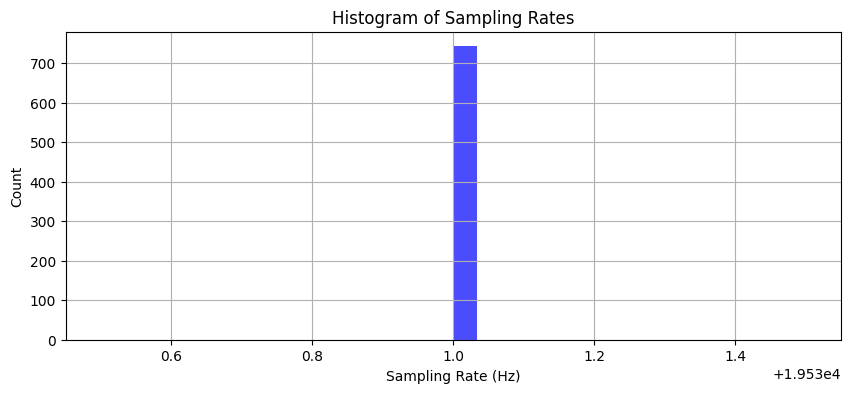

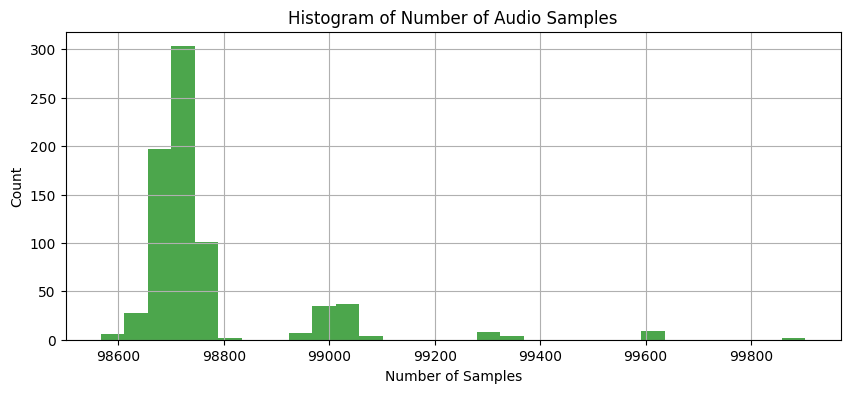

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from collections import Counter
import glob
from pydub import AudioSegment
from math import gcd
from functools import reduce
import heapq
import wave

# Path to the directory containing WAV files
data_dir = "data/"


# Function to load WAV files
def load_wav_files(directory):
    audio_files = []
    for file_name in os.listdir(directory):
        if file_name.endswith(".wav"):
            file_path = os.path.join(directory, file_name)
            sample_rate, audio = wavfile.read(file_path)
            audio_files.append((audio, sample_rate, file_name))
    return audio_files


# Load audio files
audio_files = load_wav_files(data_dir)


# Function to get WAV file info
def get_wav_info(file_path):
    with wave.open(file_path, "rb") as wav_file:
        params = wav_file.getparams()
        num_channels = params.nchannels
        sample_width = params.sampwidth
        framerate = params.framerate
        num_frames = params.nframes
        compression_type = params.compname
        bits_per_sample = sample_width * 8

        print(f"Number of Channels: {num_channels}")
        print(f"Sample Width (bytes): {sample_width}")
        print(f"Sample Rate: {framerate} Hz")
        print(f"Number of Frames: {num_frames}")
        print(f"Compression Type: {compression_type}")
        print(f"Bits per Sample: {bits_per_sample}")

        return bits_per_sample


# Example usage
file_path = "data/0052503c-2849-4f41-ab51-db382103690c.wav"
bits_per_sample = get_wav_info(file_path)

# Determine data type
if bits_per_sample == 8:
    data_type = "uint8"
elif bits_per_sample == 16:
    data_type = "int16"
elif bits_per_sample == 24:
    data_type = "int24"
elif bits_per_sample == 32:
    data_type = "int32"  # or float32, depending on the format
else:
    data_type = "unknown"

print(f"Determined Data Type: {data_type}")

# Extract sampling rates and the number of samples from each audio file
sampling_rates = [sr for _, sr, _ in audio_files]
num_samples = [len(audio) for audio, _, _ in audio_files]

# Plot histogram of sampling rates
plt.figure(figsize=(10, 4))
plt.hist(sampling_rates, bins=30, color="blue", alpha=0.7)
plt.title("Histogram of Sampling Rates")
plt.xlabel("Sampling Rate (Hz)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

# Plot histogram of the number of samples
plt.figure(figsize=(10, 4))
plt.hist(num_samples, bins=30, color="green", alpha=0.7)
plt.title("Histogram of Number of Audio Samples")
plt.xlabel("Number of Samples")
plt.ylabel("Count")
plt.grid(True)
plt.show()

In [6]:
# Print the first item's sampling rate
if audio_files:
    first_sample_rate = audio_files[0][1]
    print("Sampling rate of the first audio file:", first_sample_rate)
else:
    print("No audio files loaded.")

# Initialize variables to store global min, max, data types, and smallest non-zero step size
global_min = np.inf
global_max = -np.inf
smallest_non_zero_step = np.inf
data_types = set()
all_steps = []

# Analyze each loaded audio file
for audio, _, _ in audio_files:
    # Update global min and max
    global_min = min(global_min, np.min(audio))
    global_max = max(global_max, np.max(audio))
    # Add the data type of the current audio array
    data_types.add(audio.dtype)
    # Calculate the smallest non-zero step size in this audio file
    steps = (
        np.abs(np.diff(audio, axis=-1)) if audio.ndim > 1 else np.abs(np.diff(audio))
    )
    non_zero_steps = steps[steps > 0]  # Filter out zero differences
    all_steps.extend(non_zero_steps)
    if non_zero_steps.size > 0:
        smallest_non_zero_step = min(smallest_non_zero_step, np.min(non_zero_steps))

# Calculate the GCD of all step sizes
# the GCD of all step sizes
if all_steps:
    gcd_of_steps = reduce(gcd, all_steps)
else:
    gcd_of_steps = None

# Print the results
print(f"Global Min Value: {global_min}")
print(f"Global Max Value: {global_max}")
print(f"Data Types: {data_types}")
print(f"Smallest Non-Zero Step Size: {smallest_non_zero_step}")
print(f"GCD of All Step Sizes: {gcd_of_steps}")

# Function to convert audio to a common format (e.g., mono, 16kHz)
def convert_audio_format(audio, sample_rate, target_sample_rate=16000):
    if sample_rate != target_sample_rate:
        audio = AudioSegment(
            audio.tobytes(), 
            frame_rate=sample_rate,
            sample_width=audio.dtype.itemsize, 
            channels=1
        ).set_frame_rate(target_sample_rate)
        audio = np.array(audio.get_array_of_samples())
    return audio

# Convert all audio files to the target format
target_sample_rate = 16000
converted_audio_files = [(convert_audio_format(audio, sr, target_sample_rate), target_sample_rate, fname) for audio, sr, fname in audio_files]

# Save the converted audio files
output_dir = "converted_data/"
os.makedirs(output_dir, exist_ok=True)
for audio, sr, fname in converted_audio_files:
    output_path = os.path.join(output_dir, fname)
    wavfile.write(output_path, sr, audio)

print("Audio files have been converted and saved.")

Sampling rate of the first audio file: 19531
Global Min Value: -32768
Global Max Value: 32767
Data Types: {dtype('int16')}
Smallest Non-Zero Step Size: 63
GCD of All Step Sizes: 1
Audio files have been converted and saved.


In [7]:
from collections import Counter

# Count the occurrences of each unique number of samples
num_samples_count = Counter(num_samples)

# Print the unique number of samples and their occurrences
total_count = 0
for unique_samples, count in num_samples_count.items():
    # print(f"Number of samples: {unique_samples / 19531}, Occurrences: {count}")
    total_count += count

print(f"Total number of samples: {total_count}")


Total number of samples: 743


In [20]:
from pydub import AudioSegment
import os
import glob


def get_file_size(file_path):
    """Function to get file size."""
    return os.path.getsize(file_path)


def compress_audio_to_flac(input_path, output_path):
    """Compresses an audio file to a .brainwire format."""
    audio = AudioSegment.from_file(input_path)
    # Assuming the compression logic is similar to converting to FLAC
    audio.export(output_path, format="flac")  # Use 'flac' as an example compression


def process_audio_files(directory, compression_func):
    """Applies a compression function to all audio files in a directory."""
    wav_files_path = os.path.join(directory, "*.wav")
    wav_files = glob.glob(wav_files_path)

    size_differences = []
    max_diff = -1
    min_diff = float("inf")
    max_file_pair = None
    min_file_pair = None

    for wav_file in wav_files:
        original_size = get_file_size(wav_file)
        output_path = wav_file.replace(".wav", ".brainwire")

        compression_func(wav_file, output_path)

        compressed_size = get_file_size(output_path)
        compression_ratio = compressed_size / original_size if original_size > 0 else 0

        size_differences.append(compression_ratio)

        if compression_ratio > max_diff:
            max_diff = compression_ratio
            max_file_pair = (wav_file, output_path, original_size, compressed_size)

        if compression_ratio < min_diff:
            min_diff = compression_ratio
            min_file_pair = (wav_file, output_path, original_size, compressed_size)

    average_diff = (
        sum(size_differences) / len(size_differences) if size_differences else 0
    )

    print(
        f"File with largest compression ratio: {max_file_pair[0]} (original) -> {max_file_pair[1]} (compressed), Ratio: {max_diff}, Original Size: {max_file_pair[2]} bytes, Compressed Size: {max_file_pair[3]} bytes"
    )
    print(
        f"File with smallest compression ratio: {min_file_pair[0]} (original) -> {min_file_pair[1]} (compressed), Ratio: {min_diff}, Original Size: {min_file_pair[2]} bytes, Compressed Size: {min_file_pair[3]} bytes"
    )
    print(f"Average compression ratio: {average_diff}")


# Example usage
directory = "data/"
process_audio_files(directory, compress_audio_to_flac)

File with largest compression ratio: data/b0ad441a-6a1f-4a23-8847-246620ac1b88.wav (original) -> data/b0ad441a-6a1f-4a23-8847-246620ac1b88.brainwire (compressed), Ratio: 0.9126219968073713, Original Size: 197956 bytes, Compressed Size: 180659 bytes
File with smallest compression ratio: data/3830d316-1af4-4496-be1a-553298450516.wav (original) -> data/3830d316-1af4-4496-be1a-553298450516.brainwire (compressed), Ratio: 0.27116639149518784, Original Size: 198664 bytes, Compressed Size: 53871 bytes
Average compression ratio: 0.7163040310930167


In [11]:
# Smallest non-zero step size between any two samples: 63
# Given this you should be able to losslessly compress by a few bits per val.
# 63 is 2^6 so there is a chance we can compress by 6 bits per val.

import numpy as np

# This might be a fun. It would be a "bit" annoying (heh, see what I did there?) because you would end up needing to manage
#  the bits yourself here as you aren't working with a power of 2. But the chunks of data we are working with are long enough that's probably fine.
def compress_to_uint10(audio_data):
    """
    Compresses audio data from int16 to uint10 precision.

    Parameters:
        audio_data (np.ndarray): The audio data array in int16 format.

    Returns:
        np.ndarray: The audio data compressed to uint10 precision.
    """
    # Ensure the input is of type int16
    if audio_data.dtype != np.int16:
        raise ValueError("Input audio data must be of type int16")

    # Scale the int16 data to the range of uint10
    # int16 ranges from -32768 to 32767
    # uint10 ranges from 0 to 1023
    audio_data_uint10 = ((audio_data + 32768) / 63).astype(np.uint16)

    return audio_data_uint10


# Example usage:
# Assuming `audio` is a NumPy array of audio samples in int16 format
audio_uint10 = compress_to_uint10(audio)
# print the size before and after
original_size = audio.nbytes
compressed_size = audio_uint10.nbytes
compression_ratio = original_size / compressed_size

print(f"Original size: {original_size} bytes")
print(f"Compressed size: {compressed_size} bytes")
print(f"Compression ratio: {compression_ratio:.2f}")


Original size: 161764 bytes
Compressed size: 161764 bytes
Compression ratio: 1.00


In [16]:
audio_files[0][0]



array([-352, -416, -288, ...,  287,  223, -288], dtype=int16)

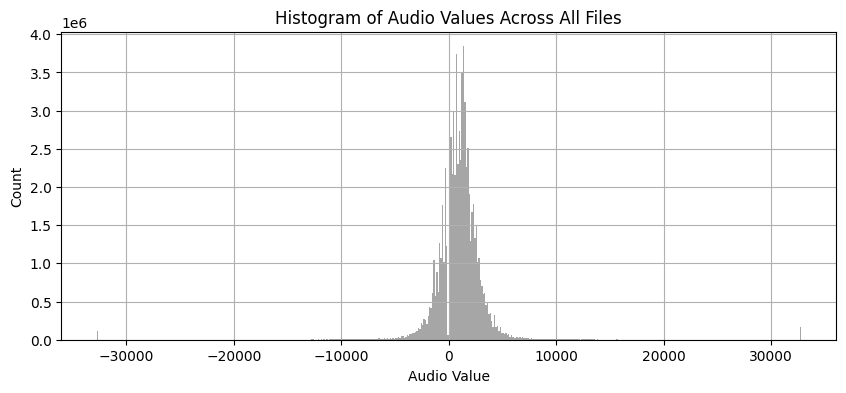

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Check if there are any audio files loaded
if audio_files:
    # Concatenate all audio data into a single array
    all_audio_data = np.concatenate(
        [audio[0] for audio in audio_files]
    )

    # Plot histogram of the concatenated audio data values
    plt.figure(figsize=(10, 4))
    plt.hist(all_audio_data, bins=500, color="gray", alpha=0.7)
    plt.title("Histogram of Audio Values Across All Files")
    plt.xlabel("Audio Value")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()
else:
    print("No audio files loaded.")

In [25]:
# Calculate the symmetric percentiles
percentile_12_5 = np.percentile(all_audio_data, 12.5)
percentile_87_5 = np.percentile(all_audio_data, 87.5)

percentile_7_5 = np.percentile(all_audio_data, 7.5)
percentile_92_5 = np.percentile(all_audio_data, 92.5)

percentile_2_5 = np.percentile(all_audio_data, 2.5)
percentile_97_5 = np.percentile(all_audio_data, 97.5)

percentile_0_5 = np.percentile(all_audio_data, 0.5)
percentile_99_5 = np.percentile(all_audio_data, 99.5)



print("75% of the data falls between", percentile_12_5, "and", percentile_87_5)
print(f"85% of the data falls between {percentile_7_5} and {percentile_92_5}")
print(f"95% of the data falls between {percentile_2_5} and {percentile_97_5}")
print(f"99% of the data falls between {percentile_0_5} and {percentile_99_5}")

75% of the data falls between -801.0 and 2658.0
85% of the data falls between -1377.0 and 3234.0
95% of the data falls between -2851.0 and 4643.0
99% of the data falls between -10026.0 and 12971.0


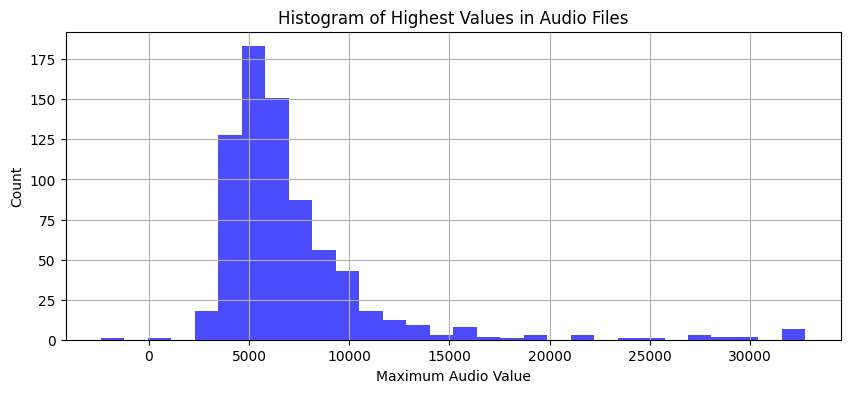

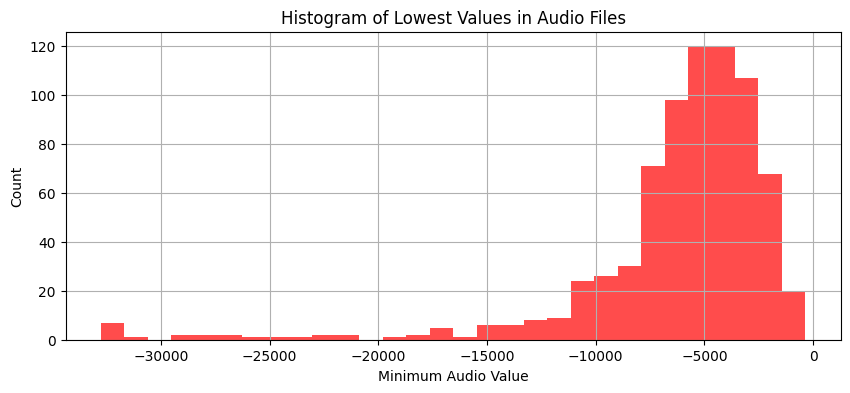

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Check if there are any audio files loaded
if audio_files:
    # Initialize lists to store the highest and lowest values for each file
    max_values = []
    min_values = []

    # Extract the max and min values from each audio file
    for audio in audio_files:
        max_values.append(np.max(audio[0]))
        min_values.append(np.min(audio[0]))

    # Plot histogram of the highest values
    plt.figure(figsize=(10, 4))
    plt.hist(max_values, bins=30, color="blue", alpha=0.7)
    plt.title("Histogram of Highest Values in Audio Files")
    plt.xlabel("Maximum Audio Value")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()

    # Plot histogram of the lowest values
    plt.figure(figsize=(10, 4))
    plt.hist(min_values, bins=30, color="red", alpha=0.7)
    plt.title("Histogram of Lowest Values in Audio Files")
    plt.xlabel("Minimum Audio Value")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()
else:
    print("No audio files loaded.")

In [ ]:
import numpy as np
from collections import Counter, defaultdict
import heapq


# Function to build the Huffman Tree
def build_huffman_tree(frequencies):
    heap = [[weight, [symbol, ""]] for symbol, weight in frequencies.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        lo = heapq.heappop(heap)
        hi = heapq.heappop(heap)
        for pair in lo[1:]:
            pair[1] = "0" + pair[1]
        for pair in hi[1:]:
            pair[1] = "1" + pair[1]
        heapq.heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    return sorted(heapq.heappop(heap)[1:], key=lambda p: (len(p[-1]), p))


# Function to compress audio data using Huffman coding
def huffman_compress(audio_data):
    # Flatten the audio data
    flat_audio_data = audio_data.flatten()
    # Calculate the frequency of each value
    frequencies = Counter(flat_audio_data)
    # Build the Huffman Tree
    huffman_tree = build_huffman_tree(frequencies)
    # Create a dictionary for the Huffman codes
    huffman_dict = {symbol: code for symbol, code in huffman_tree}
    # Encode the audio data
    encoded_audio = "".join(huffman_dict[symbol] for symbol in flat_audio_data)
    return encoded_audio, huffman_dict


# Function to decompress audio data using Huffman coding
def huffman_decompress(encoded_audio, huffman_dict):
    # Create a reverse dictionary for decoding
    reverse_huffman_dict = {code: symbol for symbol, code in huffman_dict.items()}
    # Decode the audio data
    decoded_audio = []
    code = ""
    for bit in encoded_audio:
        code += bit
        if code in reverse_huffman_dict:
            decoded_audio.append(reverse_huffman_dict[code])
            code = ""
    return np.array(decoded_audio)


# Example usage
audio_data = np.array([0.1, 0.2, 0.2, 0.3, 0.1, 0.1, 0.4, 0.4, 0.4, 0.4])
encoded_audio, huffman_dict = huffman_compress(audio_data)
decoded_audio = huffman_decompress(encoded_audio, huffman_dict)

print("Original Audio Data:", audio_data)
print("Encoded Audio Data:", encoded_audio)
print("Decoded Audio Data:", decoded_audio)

In [24]:
binary_data = [format(x, '016b') for x in all_audio_data[:10000]]

# Print the binary data
for binary in binary_data:
    print(binary)

-000000101100000
-000000110100000
-000000100100000
-000000100100000
-000000010100000
0000001001100000
0000000001011111
-000000010100000
0000000011011111
0000000011011111
0000000111011111
0000010010100000
0000010011100000
0000001101100000
0000001011100000
0000010100100000
0000010011100000
0000010101100000
0000010011100000
0000001011100000
0000001010100000
0000010101100000
0000010001100000
0000010101100000
0000011011100001
0000011011100001
0000011110100001
0000011010100001
0000011101100001
0000011100100001
0000010100100000
0000010100100000
0000010111100000
0000010101100000
0000010111100000
0000011010100001
0000100010100001
0000100100100001
0000100100100001
0000100111100001
0000110010100010
0000101010100010
0000100110100001
0000011111100001
0000100001100001
0000100010100001
0000011011100001
0000011000100001
0000100110100001
0000101000100001
0000011110100001
0000100000100001
0000011000100001
0000010110100000
0000010111100000
0000010101100000
0000010101100000
0000010001100000
00000100111000